<a href="https://colab.research.google.com/github/vic-comm/deep-learning-pytorch/blob/main/age_prediction_and_gender_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# import relevant packages
import torch
import numpy as np, pandas as pd, glob, time, os, cv2
import matplotlib.pyplot as plt
import torch.nn.functional as f
import torch.optim as optim, torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms, models, datasets
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# add Codeadd Markdown

In [ ]:
from google import colab
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials=GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
def getFile_from_drive( file_id, name ):
 downloaded = drive.CreateFile({'id': file_id})
 downloaded.GetContentFile(name)
getFile_from_drive('1Z1RqRo0_JiavaZw2yzZG6WETdZQ8qX86',
 'fairface-img-margin025-trainval.zip')
getFile_from_drive('1k5vvyREmHDW5TSM9QgB04Bvc8C8_7dl-',
 'fairface-label-train.csv')
getFile_from_drive('1_rtz1M1zhvS0d5vVoXUamnohB6cJ02iJ',
 'fairface-label-val.csv')
!unzip -qq fairface-img-margin025-trainval.zip

train_data = pd.read_csv('fairface-label-train.csv')
test_data = pd.read_csv('fairface-label-val.csv')
train_data.head()

,file,age,gender,race,service_test
0,train/1.jpg,59,Male,East Asian,True
1,train/2.jpg,39,Female,Indian,False
2,train/3.jpg,11,Female,Black,False
3,train/4.jpg,26,Female,Indian,True
4,train/5.jpg,26,Female,Indian,True


In [ ]:
img_size = 224

class GenderAgeClass(Dataset):
  def __init__(self, data, transform=None):
    self.data = data
    self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    f = self.data.iloc[idx].squeeze()
    file = f.file
    gen = f.gender == 'Female'
    age = f.age
    im = cv2.imread(file)
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    return im, age, gen

  def preprocess_image(self, img):
    img = cv2.resize(img, (img_size, img_size))
    img = torch.tensor(img).permute(2, 0, 1)
    img = self.normalize(img/255)
    return img[None]

  def collate_fn(self, batch):
    imgs, ages, genders = [], [], []
    for img, age, gender in batch:
      img = self.preprocess_image(img)
      imgs.append(img)
      ages.append(float(int(age)/80))
      genders.append(float(gender))

    ages, genders = [torch.tensor(x).to(device).float() for x in [ages, genders]]
    imgs = torch.cat(imgs).to(device)
    return imgs, ages, genders

In [ ]:
train = GenderAgeClass(train_data)
test = GenderAgeClass(test_data)

In [ ]:
len(train)

86744

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_loader = DataLoader(train, batch_size=32, shuffle=True, drop_last=True,collate_fn=train.collate_fn)
test_loader = DataLoader(test, batch_size=32, collate_fn=test.collate_fn)
a,b,c, = next(iter(train_loader))
print(a.shape, b.shape, c.shape)

torch.Size([32, 3, 224, 224]) torch.Size([32]) torch.Size([32])


In [ ]:
# creating a classifier
class Age_Gender_Classifier(nn.Module):
  def __init__(self):
    super().__init__()
    self.intermediate = nn.Sequential(
                                      nn.Linear(2048,512),
                                      nn.ReLU(),
                                      nn.Dropout(0.4),
                                      nn.Linear(512,128),
                                      nn.ReLU(),
                                      nn.Dropout(0.4),
                                      nn.Linear(128,64),
                                      nn.ReLU())

    self.age_classifier = nn.Sequential(nn.Linear(64, 1),nn.Sigmoid())
    self.gender_classifier = nn.Sequential(nn.Linear(64, 1),nn.Sigmoid())

  def forward(self, x):
    x = self.intermediate(x)
    age = self.age_classifier(x)
    gender= self.gender_classifier(x)
    return age, gender

In [ ]:
# Load pretrained model and modify it
def get_model():
  model = models.vgg16(pretrained=True)
  for param in model.parameters():
    param.requires_grad = False

  model.avgpool = nn.Sequential(nn.Conv2d(512, 512, kernel_size=3), nn.MaxPool2d(2), nn.ReLU(), nn.Flatten())

  model.classifier = Age_Gender_Classifier()

  gender_loss_fn = nn.BCELoss()
  age_loss_fn = nn.L1Loss()

  loss_functions = gender_loss_fn, age_loss_fn
  optimizer = torch.optim.Adam(model.parameters(),lr= 1e-4)
  return model.to(device), loss_functions, optimizer

In [ ]:
model, loss_fn, optimizer = get_model()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:04<00:00, 133MB/s] 


In [ ]:
# training and evaluating the model
def train_batch(data, model, optimizer, criteria):
  imgs, age, gender = data
  model.train()
  optimizer.zero_grad()
  gender_criteria, age_criteria = criteria
  pred_gender, pred_age = model(imgs)
  gender_loss = gender_criteria(pred_gender.squeeze(), gender)
  age_loss = age_criteria(pred_age.squeeze(), age)
  total_loss = gender_loss + age_loss
  total_loss.backward()
  optimizer.step()
  return total_loss

def validate_batch(data, model, criteria):
  model.eval()
  imgs, age, gender = data
  with torch.no_grad():
    pred_gender, pred_age = model(imgs)
  gender_criterion, age_criterion = criteria
  gender_loss = gender_criterion(pred_gender.squeeze(), gender)
  age_loss = age_criterion(pred_age.squeeze(), age)

  total_loss = gender_loss + age_loss
  pred_gender = (pred_gender > 0.5).squeeze()
  gender_acc = (pred_gender == gender).float().sum()
  age_mae = torch.abs(age - pred_age).float().sum()
  return total_loss, gender_acc, age_mae

In [ ]:
import time
model, criteria, optimizer = get_model()
val_gender_accuracies = []
val_age_maes = []
train_losses = []
val_losses = []
n_epochs = 10
best_test_loss = 1000
start = time.time()

for epoch in range(n_epochs):
  epoch_train_loss, epoch_test_loss = 0, 0
  val_age_mae, val_gender_acc, ctr = 0, 0, 0
  _n = len(train_loader)
  for ix, data in enumerate(train_loader):
    loss = train_batch(data, model, optimizer, criteria)
    epoch_train_loss += loss.item()
  for ix, data in enumerate(test_loader):
    loss, gender_acc, age_mae = validate_batch(data, \
    model, criteria)
    epoch_test_loss += loss.item()
    val_age_mae += age_mae
    val_gender_acc += gender_acc
    ctr += len(data[0])
  val_age_mae /= ctr
  val_gender_acc /= ctr
  epoch_train_loss /= len(train_loader)
  epoch_test_loss /= len(test_loader)

  elapsed = time.time()-start
  best_test_loss = min(best_test_loss, epoch_test_loss)
  print('{}/{} ({:.2f}s - {:.2f}s remaining)'.format(epoch+1, n_epochs, time.time()-start,(n_epochs-epoch)*(elapsed/(epoch+1))))
  info = f'''Epoch: {epoch+1:03d}\tTrain Loss: {epoch_train_loss:.3f}\tTest:{epoch_test_loss:.3f}\tBest Test Loss: {best_test_loss:.4f}'''
  info += f'\nGender Accuracy: {val_gender_acc*100:.2f}%\tAge MAE: {val_age_mae:.2f}\n'
  print(info)

  val_gender_accuracies.append(val_gender_acc)
  val_age_maes.append(val_age_mae)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


1/10 (793.43s - 7934.35s remaining)
Epoch: 001	Train Loss: 0.547	Test:0.469	Best Test Loss: 0.4685
Gender Accuracy: 83.32%	Age MAE: 6.12

2/10 (1593.54s - 7170.93s remaining)
Epoch: 002	Train Loss: 0.398	Test:0.454	Best Test Loss: 0.4541
Gender Accuracy: 84.35%	Age MAE: 6.30

3/10 (2399.19s - 6397.83s remaining)
Epoch: 003	Train Loss: 0.280	Test:0.496	Best Test Loss: 0.4541
Gender Accuracy: 84.81%	Age MAE: 6.44

4/10 (3202.15s - 5603.76s remaining)
Epoch: 004	Train Loss: 0.193	Test:0.625	Best Test Loss: 0.4541
Gender Accuracy: 83.70%	Age MAE: 6.36

5/10 (4006.14s - 4807.36s remaining)
Epoch: 005	Train Loss: 0.155	Test:0.701	Best Test Loss: 0.4541
Gender Accuracy: 83.95%	Age MAE: 6.33

6/10 (4804.71s - 4003.92s remaining)
Epoch: 006	Train Loss: 0.137	Test:0.831	Best Test Loss: 0.4541
Gender Accuracy: 83.98%	Age MAE: 6.54

7/10 (5604.24s - 3202.42s remaining)
Epoch: 007	Train Loss: 0.125	Test:0.875	Best Test Loss: 0.4541
Gender Accuracy: 83.20%	Age MAE: 6.39

8/10 (6410.37s - 2403.89s re

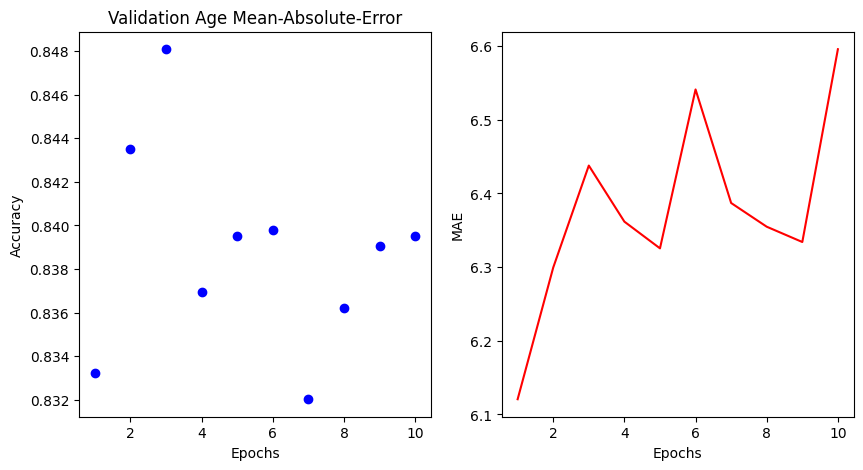

In [ ]:
val_gender_accuracies_cpu = []
for i in val_gender_accuracies:
  val_gender_accuracies_cpu.append(i.cpu().numpy())
val_age_maes_cpu = []
for x in val_age_maes:
  val_age_maes_cpu.append(x.cpu().numpy())
epochs = np.arange(1,(n_epochs+1))
fig,ax = plt.subplots(1,2,figsize=(10,5))
ax = ax.flat
ax[0].plot(epochs, val_gender_accuracies_cpu, 'bo')
ax[1].plot(epochs, val_age_maes_cpu, 'r')
ax[0].set_xlabel('Epochs') ; ax[1].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy'); ax[1].set_ylabel('MAE')
ax[0].set_title('Validation Gender Accuracy')
ax[0].set_title('Validation Age Mean-Absolute-Error')
plt.show()

--2024-07-07 04:03:49--  https://www.dropbox.com/s/6kzr8l68e9kpjkf/5_9.JPG
Resolving www.dropbox.com (www.dropbox.com)... 162.125.65.18, 2620:100:6017:18::a27d:212
Connecting to www.dropbox.com (www.dropbox.com)|162.125.65.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.dropbox.com/scl/fi/sfbawr98071sitjngi47f/5_9.JPG?rlkey=pqubht9wr7taee7kh52cng40n [following]
--2024-07-07 04:03:50--  https://www.dropbox.com/scl/fi/sfbawr98071sitjngi47f/5_9.JPG?rlkey=pqubht9wr7taee7kh52cng40n
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucdf8741e84c7ebcd7c51fb711c0.dl.dropboxusercontent.com/cd/0/inline/CWPhTJ3WBNrDDTyx4SMkVU-ncg8EAJYreD9MeBqVyOdrsV2VGALrjcgaC2l12P37h83Qw3eHghE5buYqE1DwA1exMybe3mdk9IYjwbpFUpi5KRQtAUKyoKkY3qOacozJsdkfd-WkvE7zjrPgL_lku8kn/file# [following]
--2024-07-07 04:03:51--  https://ucdf8741e84c7ebcd7c51fb711c0.dl.dropboxusercontent.com/cd/0/inline/CWPhTJ3WBNrDDT

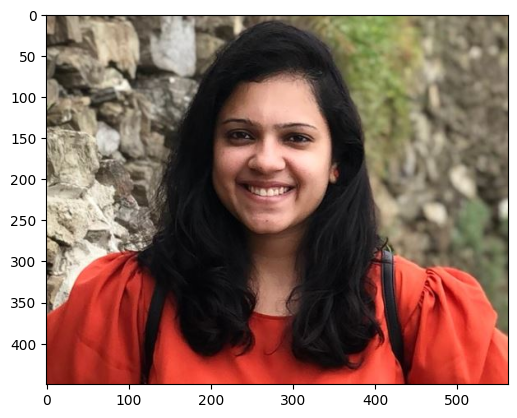

In [ ]:
!wget https://www.dropbox.com/s/6kzr8l68e9kpjkf/5_9.JPG
im = cv2.imread('/content/5_9.JPG')
im = train.preprocess_image(im).to(device)
gender, age = model(im)
pred_gender = gender.to('cpu').detach().numpy()
pred_age = age.to('cpu').detach().numpy()
im = cv2.imread('/content/5_9.JPG')
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
plt.imshow(im)
print('predicted gender:',np.where(pred_gender[0][0]<0.5,'Male','Female'),'; Predicted age', int(pred_age[0][0]*80))

In [ ]:
import os
#  saving the model
torch.save(model.state_dict(), 'age_prediction_and_gender_classification.txt')
loaded_model = model()
loaded_model.load_state_dict(torch.load('age_prediction_and_gender_classification.t'))

TypeError: VGG.forward() missing 1 required positional argument: 'x'